In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
df = pd.read_csv("flights.csv")

In [17]:
df.head()

,index,Airline,Date_of_Journey,Source,Destination,Dep_Time,Duration,Total_Stops,Additional_Info,Price
0,0,Jet Airways,2019-01-03,Banglore,New Delhi,11:40,13h 5m,1 stop,No info,26890
1,1,SpiceJet,2019-01-03,Banglore,New Delhi,15:35,8h 5m,1 stop,1 Long layover,7744
2,2,Jet Airways,2019-01-03,Banglore,New Delhi,8:00,12h 20m,1 stop,No info,27992
3,3,Air India,2019-01-03,Banglore,New Delhi,8:50,39h 5m,2 stops,No info,17135
4,4,Jet Airways,2019-01-03,Banglore,New Delhi,11:40,23h 45m,1 stop,No info,25735


In [20]:
import pandas as pd



# Drop unnecessary columns
df = df.drop(columns=['index', 'Total_Stops', 'Additional_Info'])

# Convert 'Date_of_Journey' to datetime
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], format='%Y-%m-%d', errors='coerce')

# Drop rows with invalid dates
df = df.dropna(subset=['Date_of_Journey'])

# Check date range
print("Date range in dataset:", df['Date_of_Journey'].min(), "to", df['Date_of_Journey'].max())


Date range in dataset: 2019-01-03 00:00:00 to 2019-12-06 00:00:00


In [21]:
df = df[['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Dep_Time', 'Duration', 'Price']]


In [22]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Duration,Price
0,Jet Airways,2019-01-03,Banglore,New Delhi,11:40,13h 5m,26890
1,SpiceJet,2019-01-03,Banglore,New Delhi,15:35,8h 5m,7744
2,Jet Airways,2019-01-03,Banglore,New Delhi,8:00,12h 20m,27992
3,Air India,2019-01-03,Banglore,New Delhi,8:50,39h 5m,17135
4,Jet Airways,2019-01-03,Banglore,New Delhi,11:40,23h 45m,25735


In [23]:
# Ensure Price is numeric
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Drop rows with invalid Price
df = df.dropna(subset=['Price'])

# Convert to int
df['Price'] = df['Price'].astype(int)


In [24]:
# Extract month
df['Month'] = df['Date_of_Journey'].dt.month

# Map month to Indian season
def indian_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Summer'
    elif month in [6, 7, 8, 9]:
        return 'Monsoon'
    else:  # 10, 11
        return 'Post-Monsoon'

df['Season'] = df['Month'].apply(indian_season)

# Check how many flights in each season
print(df['Season'].value_counts())


Season
Summer     4709
Monsoon    3942
Winter     2032
Name: count, dtype: int64


In [25]:
def duration_to_minutes(duration):
    h, m = 0, 0
    parts = duration.split(' ')
    for part in parts:
        if 'h' in part:
            h = int(part.replace('h',''))
        elif 'm' in part:
            m = int(part.replace('m',''))
    return h*60 + m

df['Duration_min'] = df['Duration'].apply(duration_to_minutes)


In [26]:
df['Dep_hour'] = pd.to_datetime(df['Dep_Time'], format='%H:%M').dt.hour


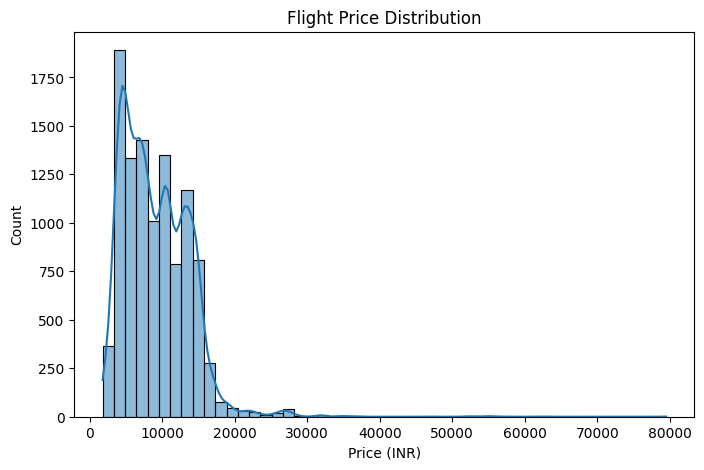

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df['Price'], bins=50, kde=True)
plt.title("Flight Price Distribution")
plt.xlabel("Price (INR)")
plt.ylabel("Count")
plt.show()


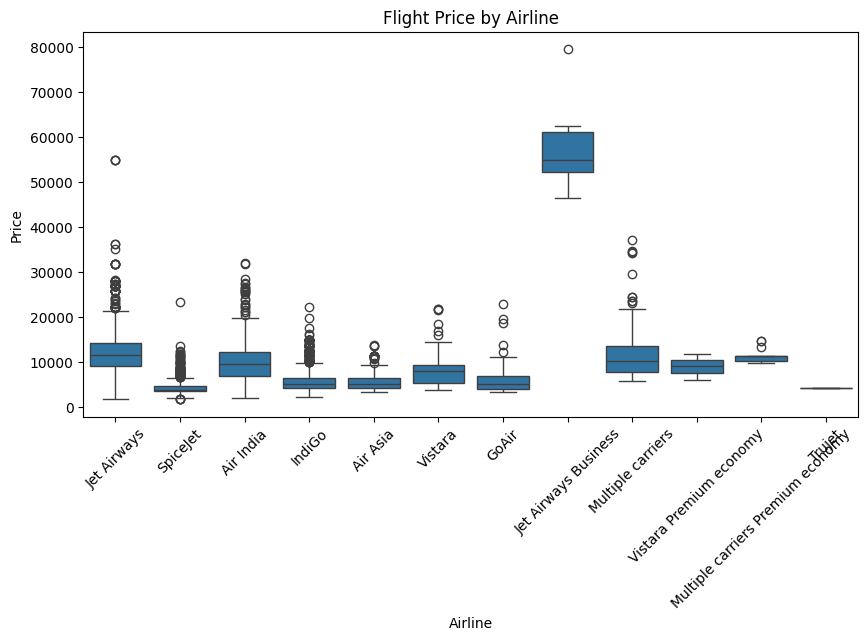

In [28]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Airline', y='Price', data=df)
plt.xticks(rotation=45)
plt.title("Flight Price by Airline")
plt.show()


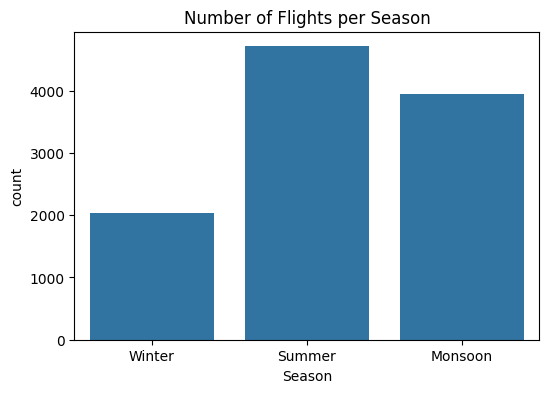

In [29]:
plt.figure(figsize=(6,4))
sns.countplot(x='Season', data=df)
plt.title("Number of Flights per Season")
plt.show()


In [30]:
# Calculate Q1, Q3, and IQR
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

# Keep only rows within 1.5 * IQR
df_no_outliers = df[(df['Price'] >= Q1 - 1.5*IQR) & (df['Price'] <= Q3 + 1.5*IQR)]


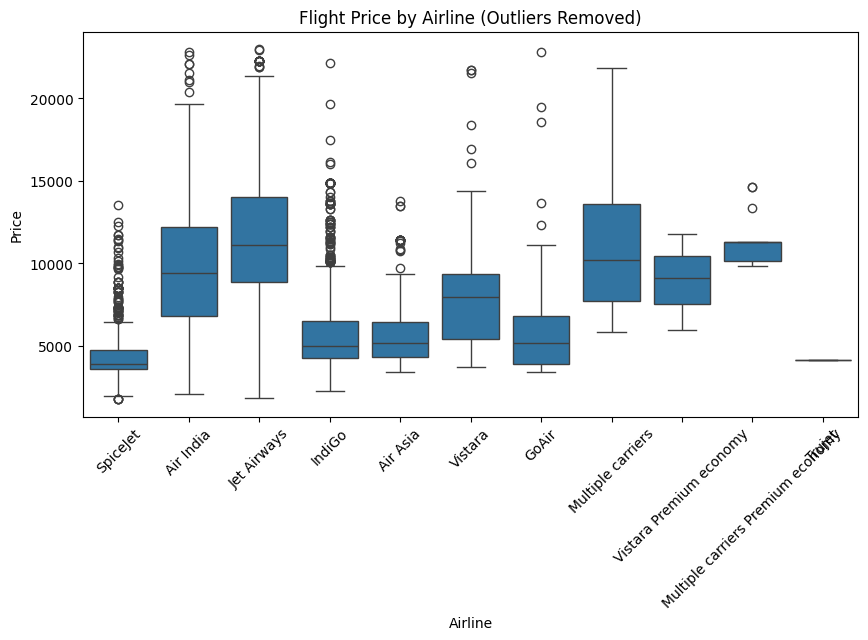

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.boxplot(x='Airline', y='Price', data=df_no_outliers)
plt.xticks(rotation=45)
plt.title("Flight Price by Airline (Outliers Removed)")
plt.show()


In [32]:
# Replace original df with outlier-cleaned version
df = df_no_outliers.copy()


In [33]:
# Group by month and calculate mean price
monthly_prices = df.groupby('Month')['Price'].mean().reset_index()

# Map month to season
def indian_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Summer'
    elif month in [6, 7, 8, 9]:
        return 'Monsoon'
    else:
        return 'Post-Monsoon'

monthly_prices['Season'] = monthly_prices['Month'].apply(indian_season)


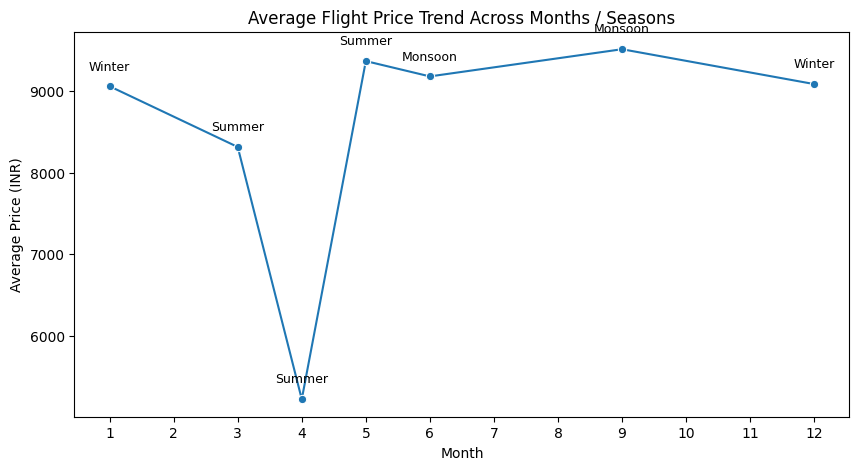

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.lineplot(x='Month', y='Price', data=monthly_prices, marker='o')
plt.xticks(range(1,13))
plt.title("Average Flight Price Trend Across Months / Seasons")
plt.xlabel("Month")
plt.ylabel("Average Price (INR)")

# Annotate each point with the corresponding season
for i, row in monthly_prices.iterrows():
    plt.text(row['Month'], row['Price']+200, row['Season'], ha='center', fontsize=9)

plt.show()


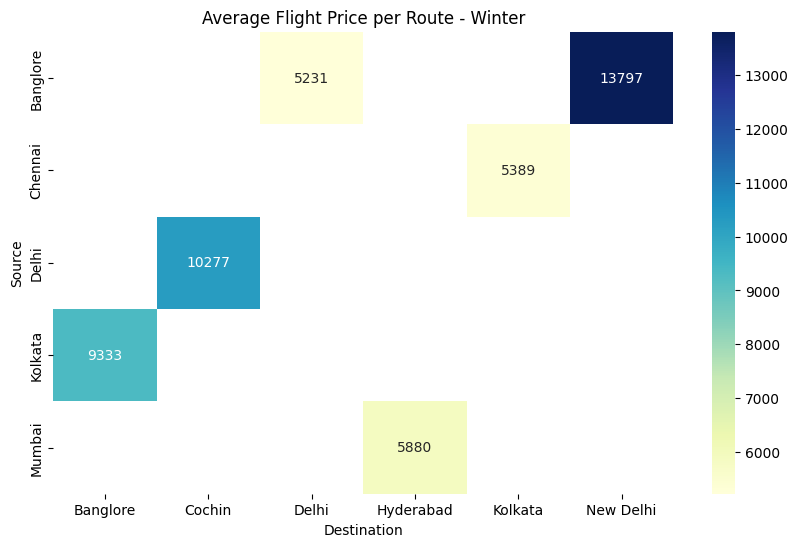

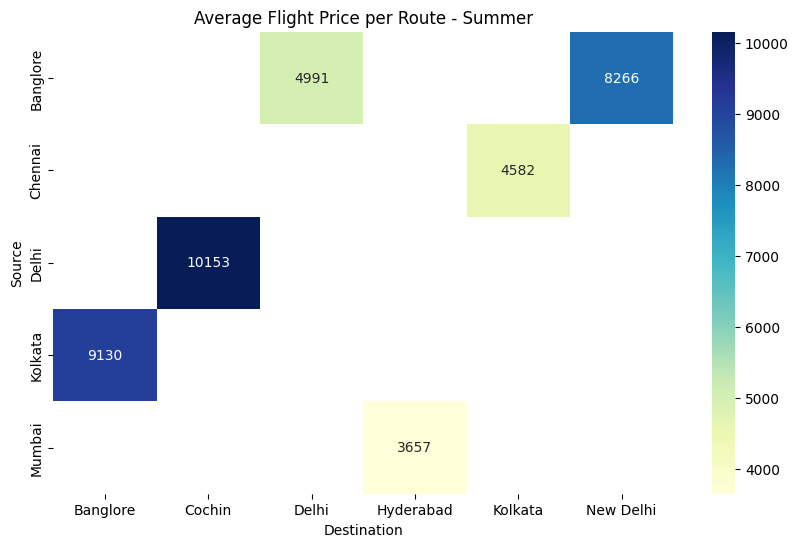

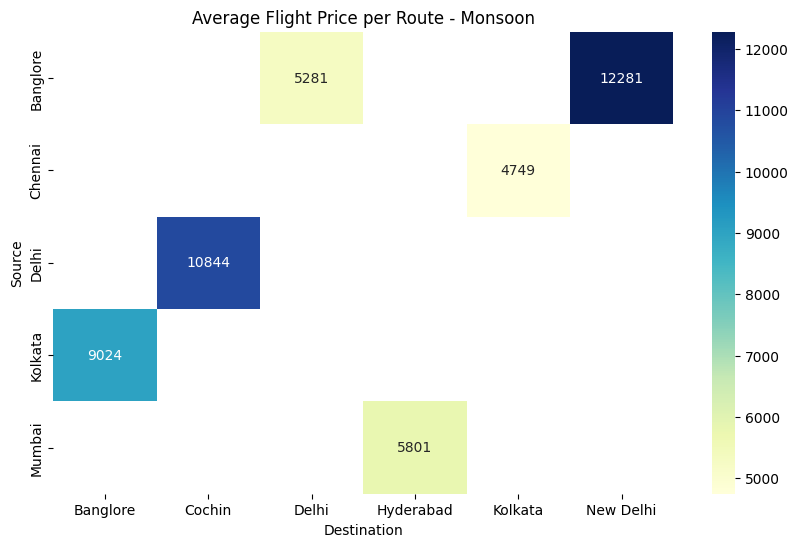

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique seasons
seasons = df['Season'].unique()

# Generate heatmaps for each season
for season in seasons:
    pivot = df[df['Season'] == season].pivot_table(
        index='Source',
        columns='Destination',
        values='Price',
        aggfunc='mean'
    )
    plt.figure(figsize=(10,6))
    sns.heatmap(pivot, annot=True, fmt=".0f", cmap='YlGnBu')
    plt.title(f"Average Flight Price per Route - {season}")
    plt.ylabel("Source")
    plt.xlabel("Destination")
    plt.show()


In [ ]:
# K-Means Clustering for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# -----------------------------
# 1. Select numerical features for clustering
# -----------------------------
num_features = ['Duration_min', 'Price', 'Dep_hour', 'Dep_minute', 'Weekday']

df_cluster = df[num_features].copy()
df_cluster.dropna(inplace=True)

# -----------------------------
# 2. Scale the dataset
# -----------------------------
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_cluster)

# -----------------------------
# 3. Elbow Method to choose correct K
# -----------------------------
inertia = []
K_range = range(1, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_data)
    inertia.append(km.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Method: Choose Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

# -----------------------------
# 4. Train K-Means with chosen K
# -----------------------------
k = 3  # change based on elbow result
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

df['Cluster'] = clusters

# -----------------------------
# 5. Visualize clusters
# -----------------------------
plt.figure(figsize=(7, 5))
sns.scatterplot(
    x=df['Duration_min'],
    y=df['Price'],
    hue=df['Cluster'],
    palette="viridis"
)
plt.title("K-Means Clusters: Duration vs Price")
plt.xlabel("Duration (min)")
plt.ylabel("Ticket Price")
plt.show()

plt.figure(figsize=(7, 5))
sns.scatterplot(
    x=df['Dep_hour'],
    y=df['Price'],
    hue=df['Cluster'],
    palette="viridis"
)
plt.title("K-Means Clusters: Departure Hour vs Price")
plt.xlabel("Departure Hour")
plt.ylabel("Ticket Price")
plt.show()


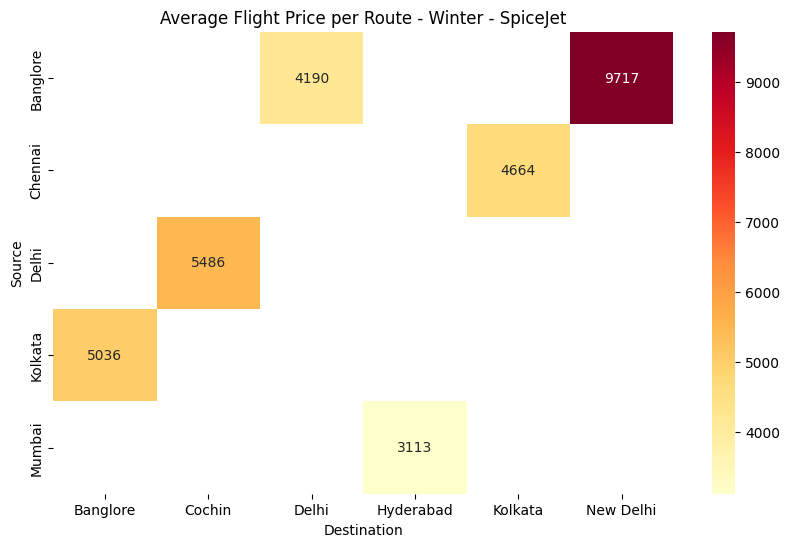

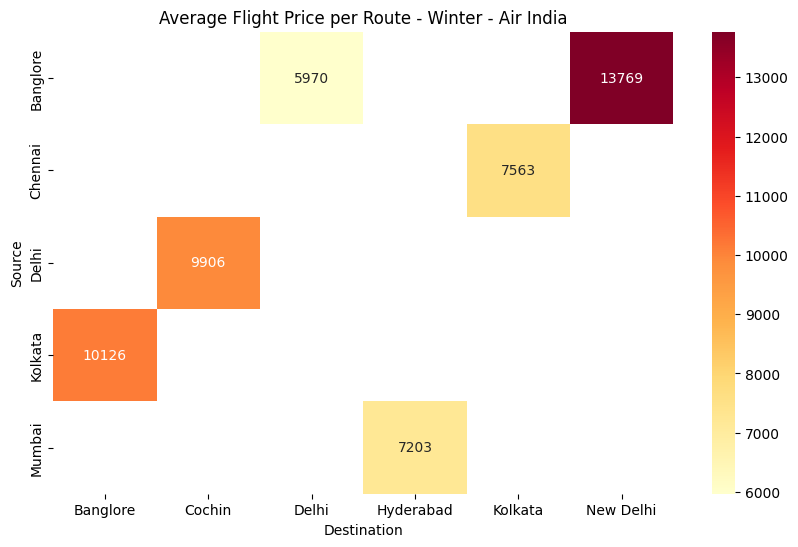

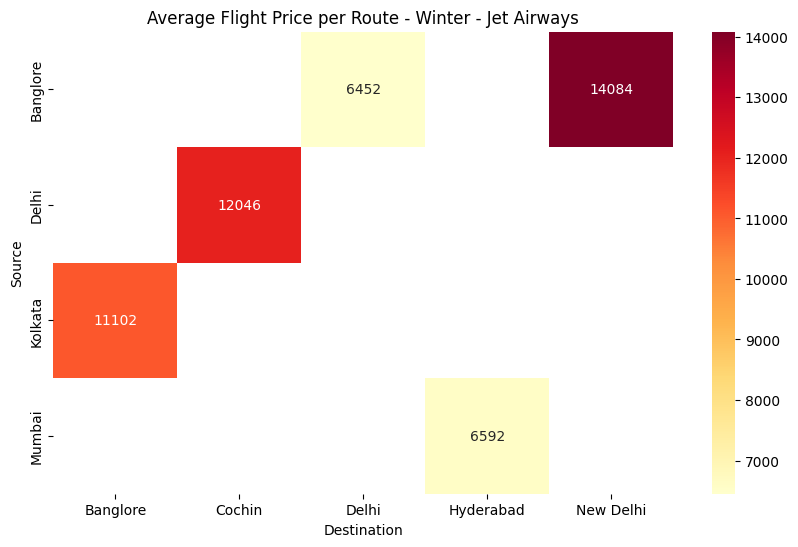

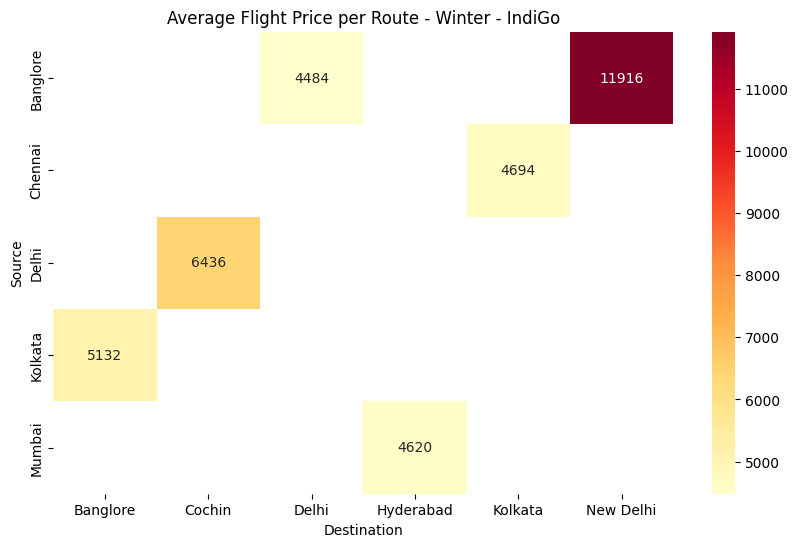

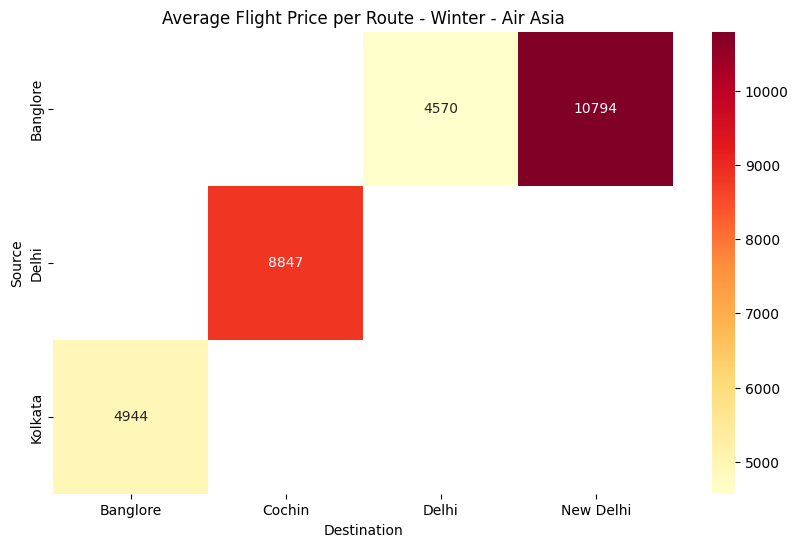

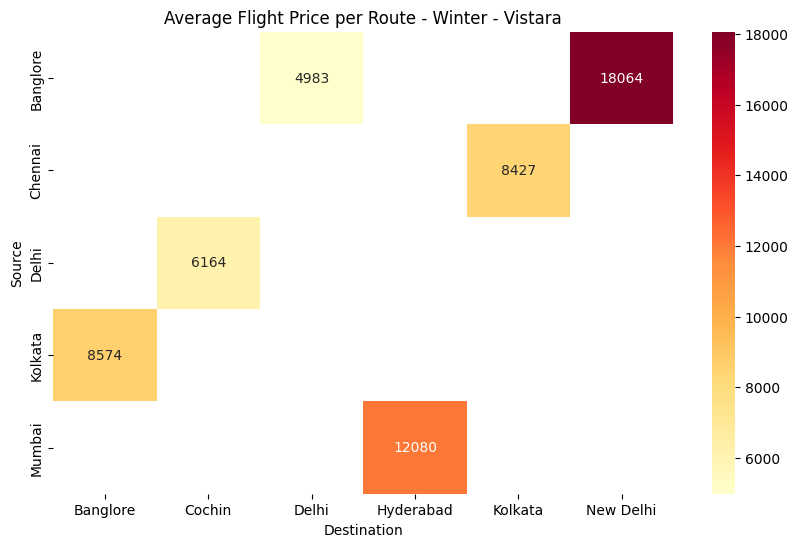

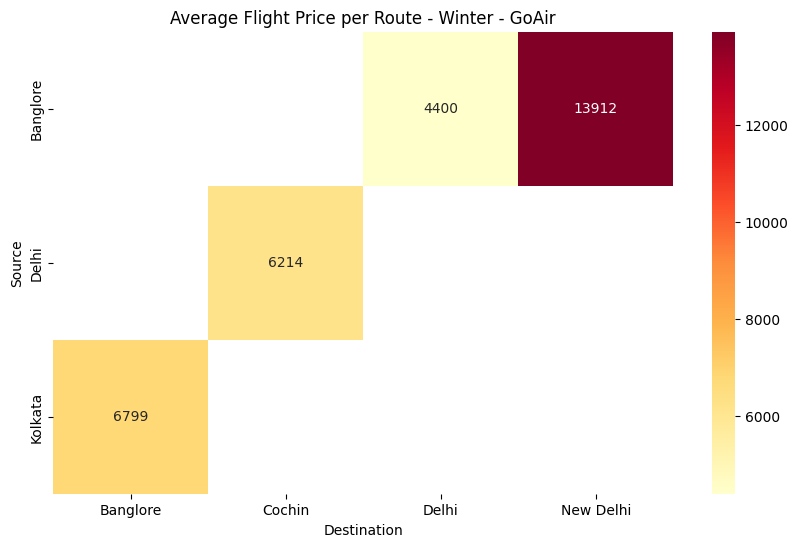

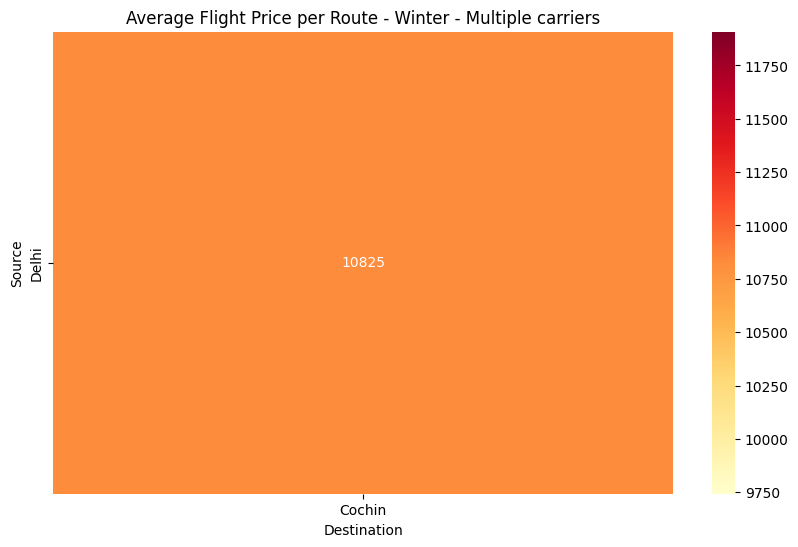

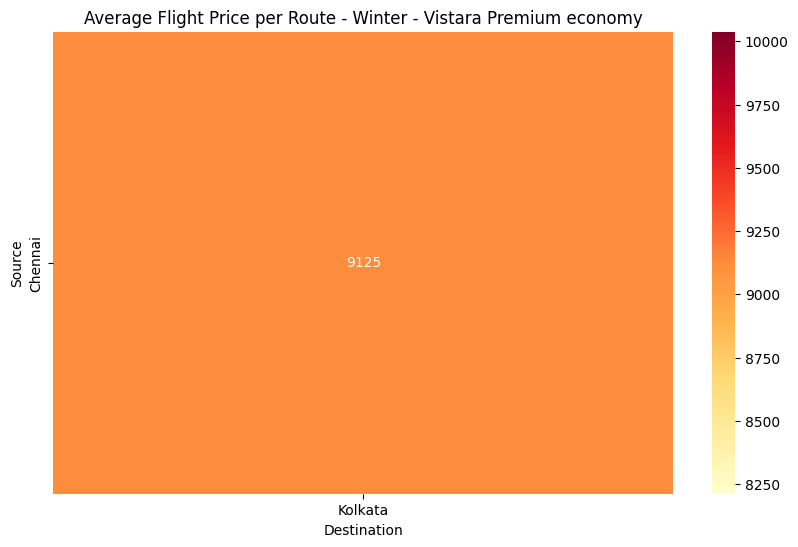

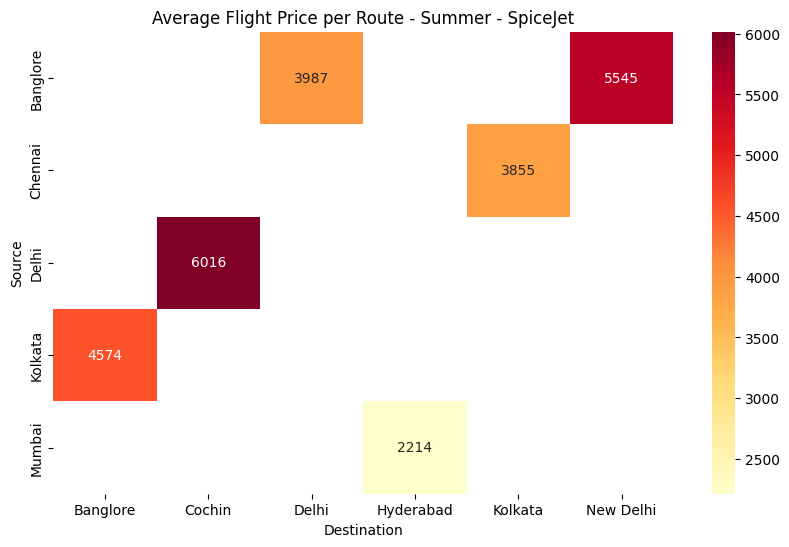

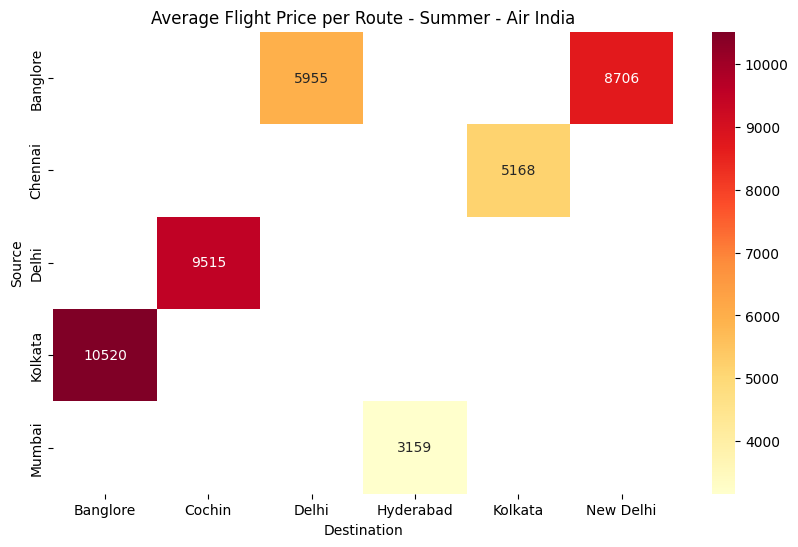

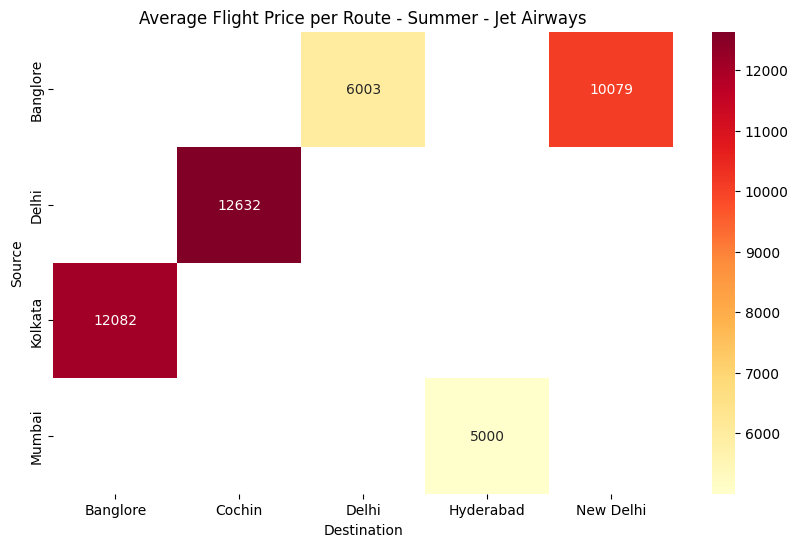

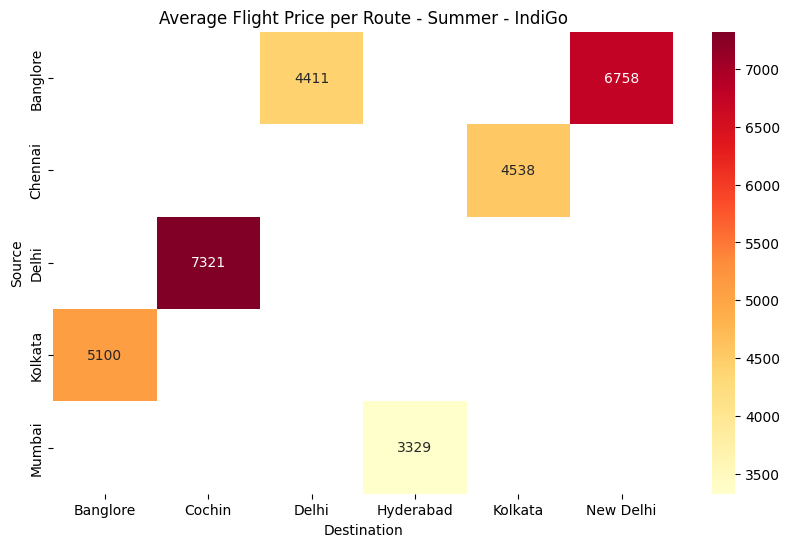

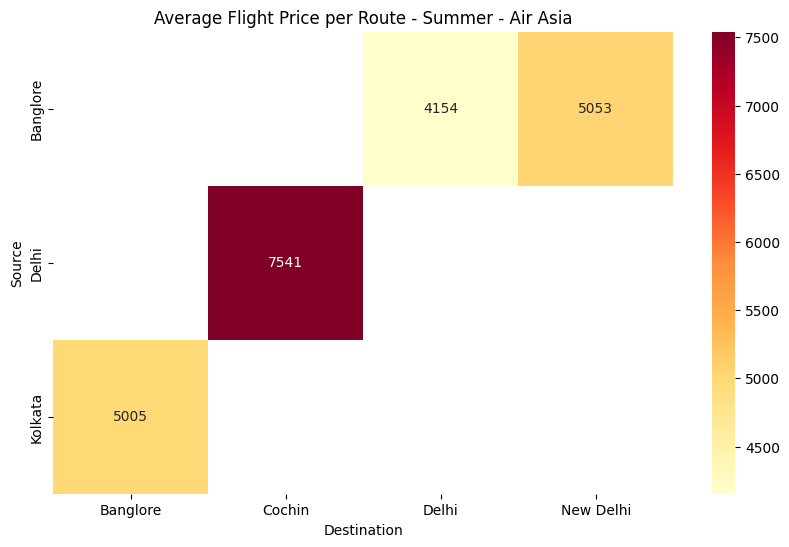

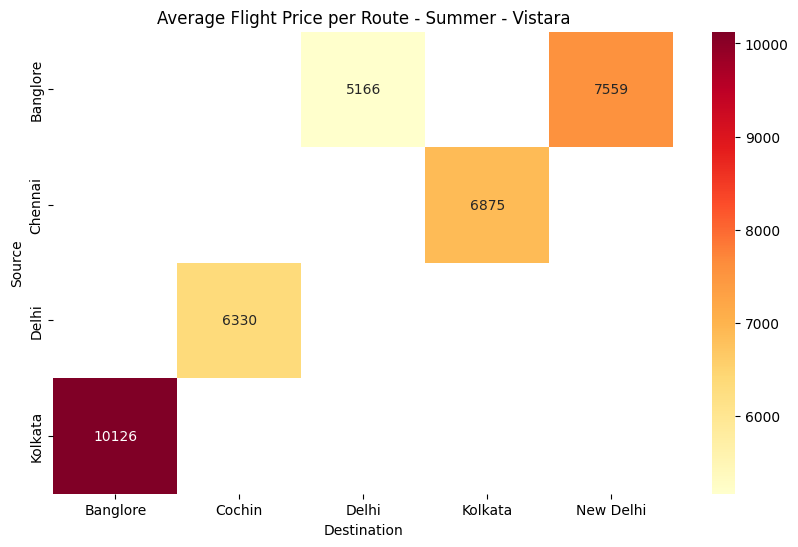

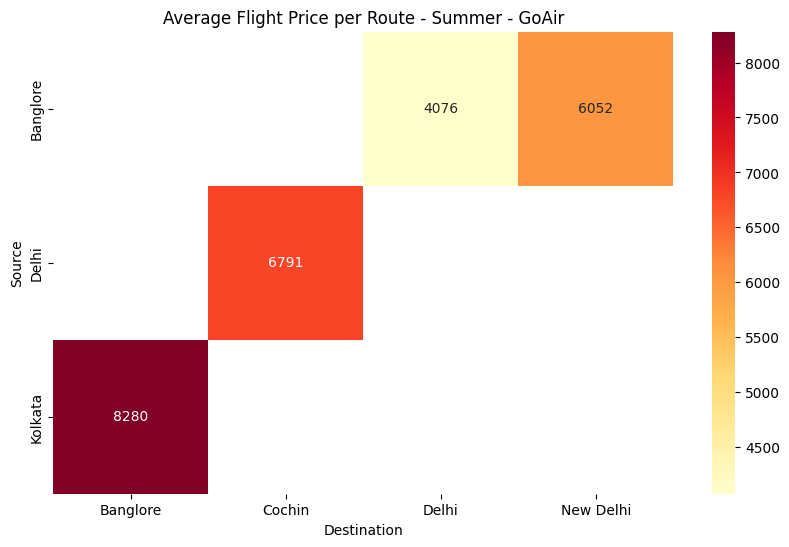

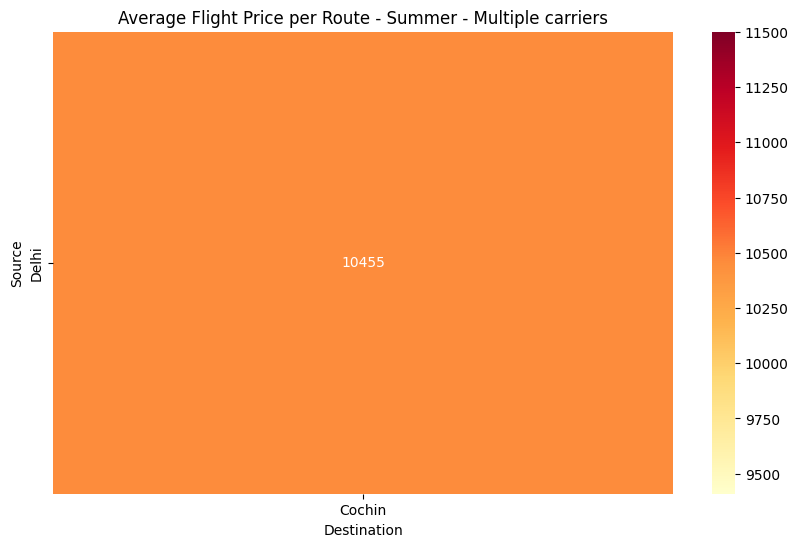

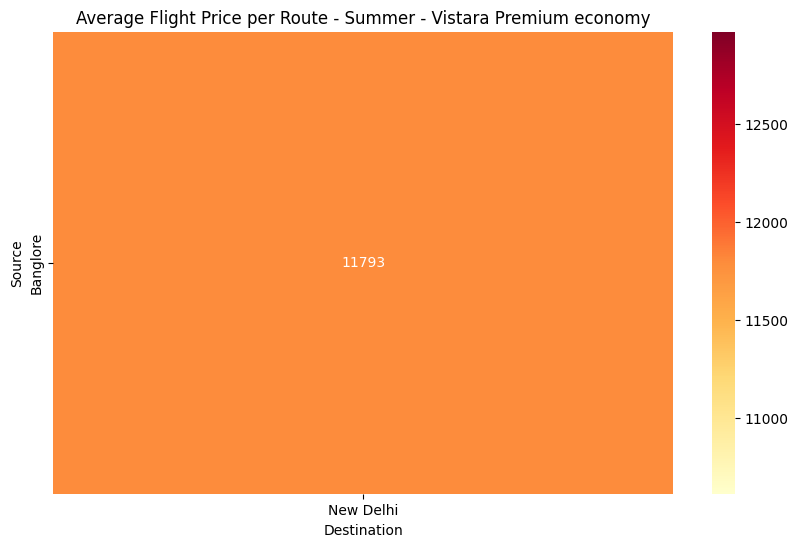

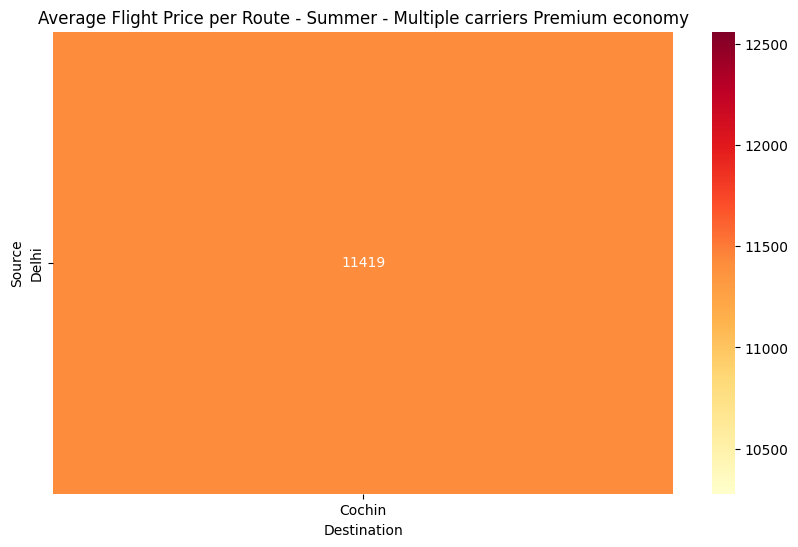

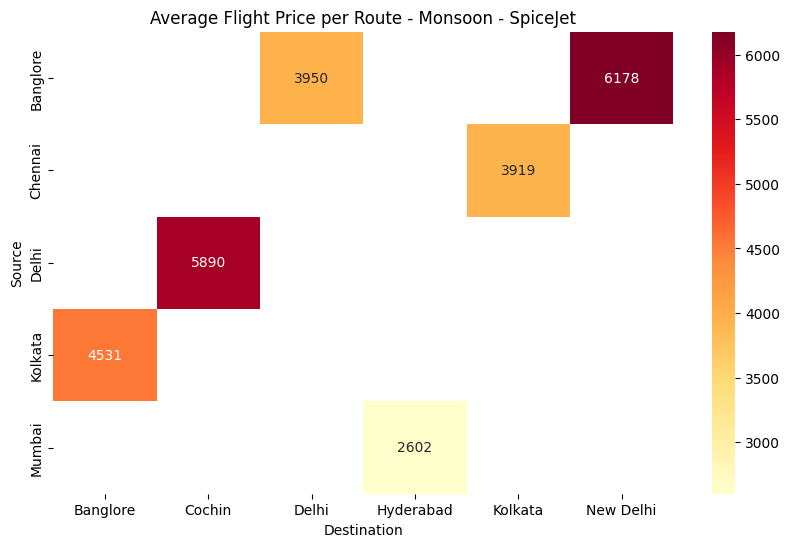

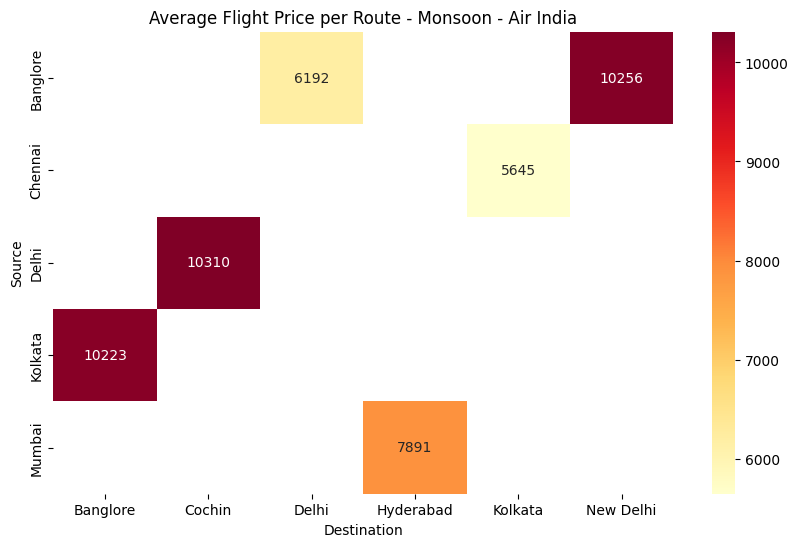

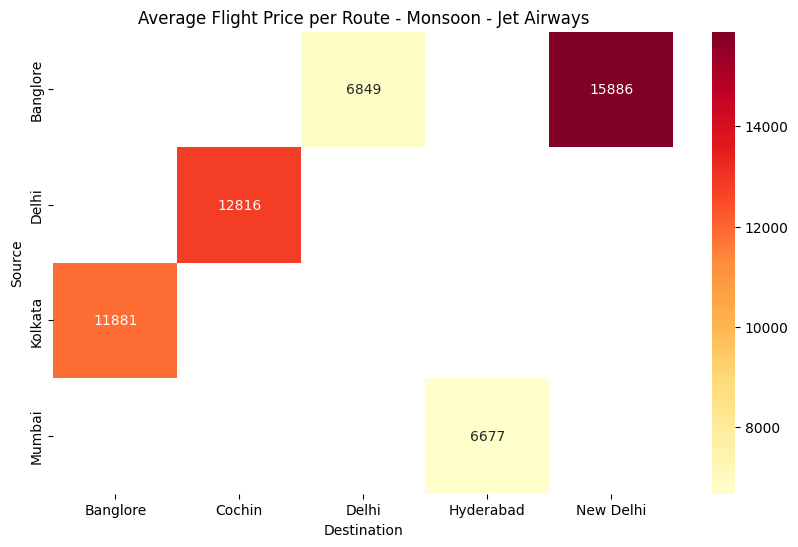

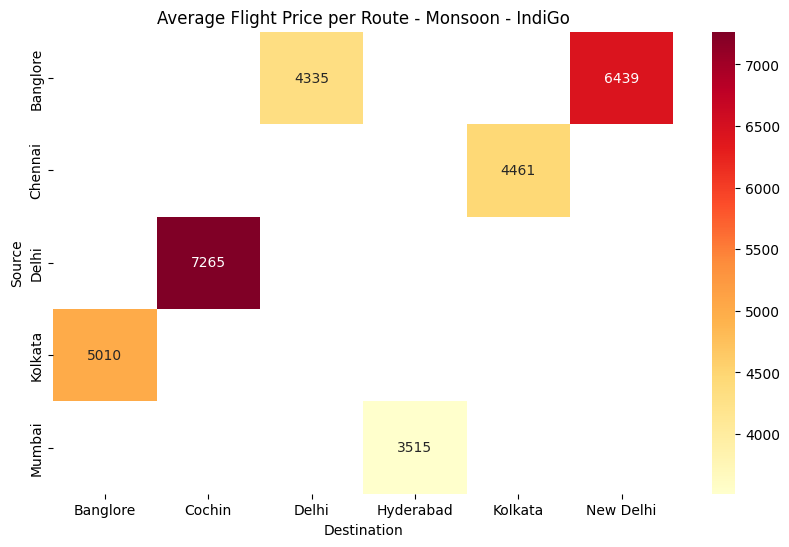

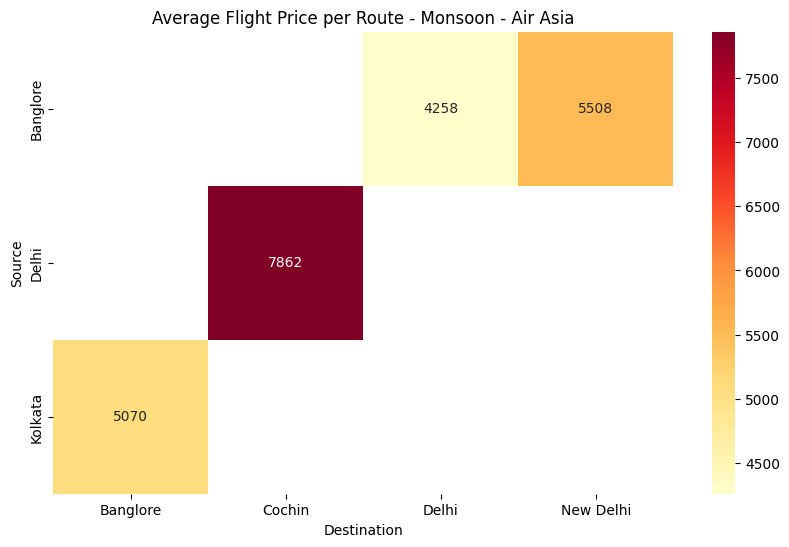

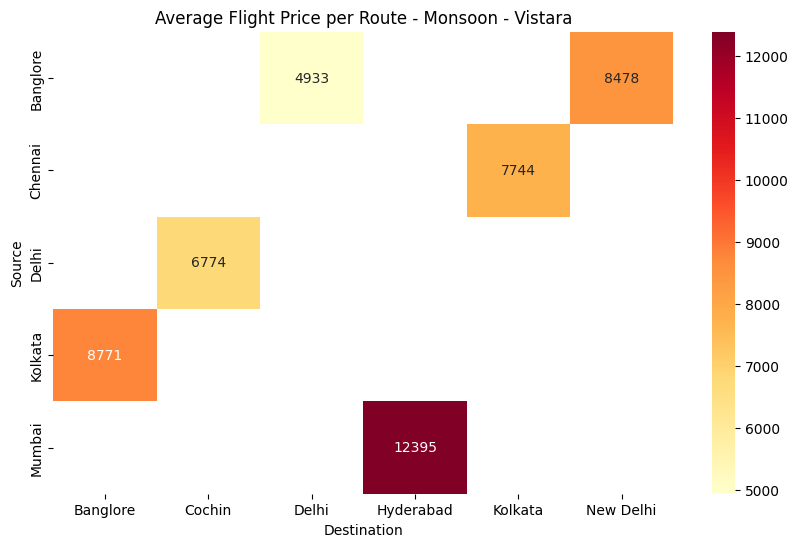

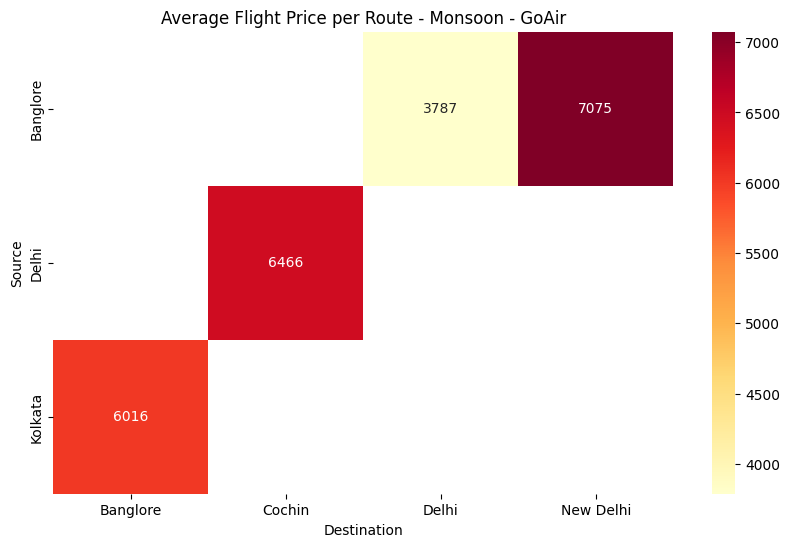

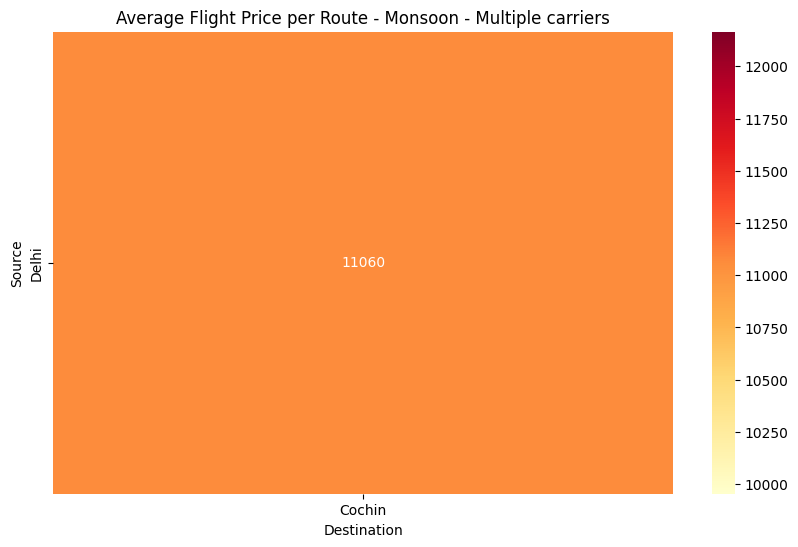

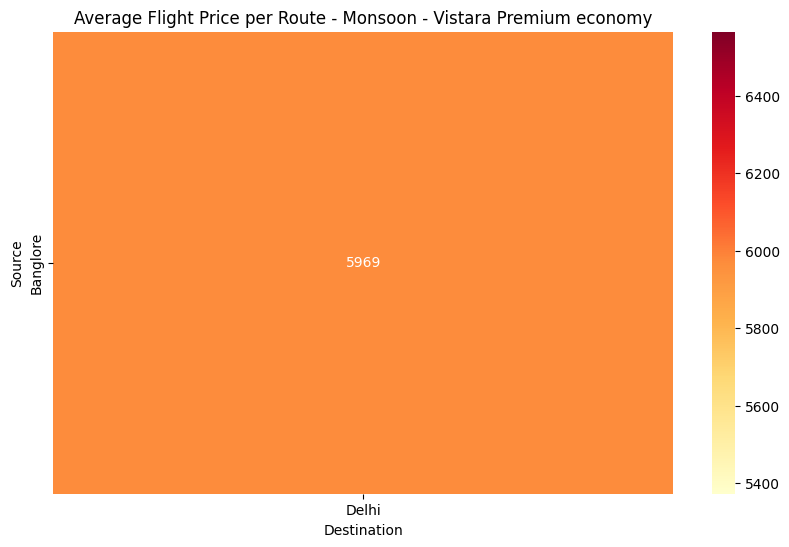

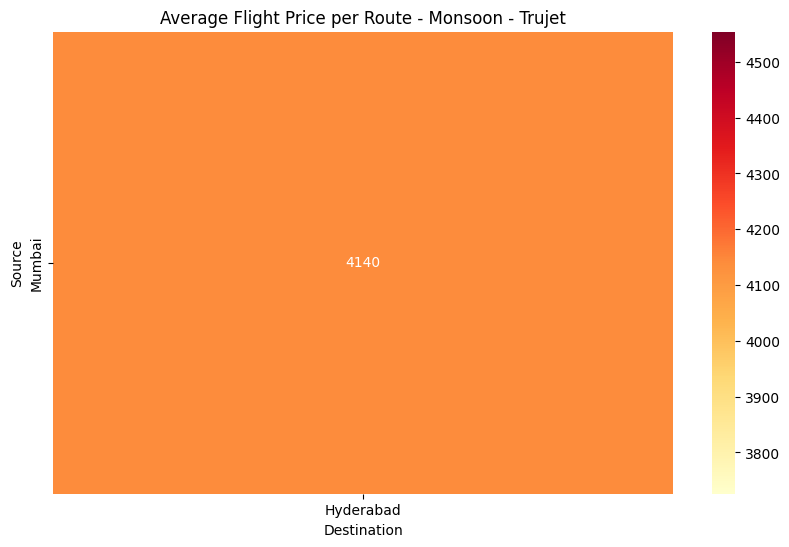

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

seasons = df['Season'].unique()
airlines = df['Airline'].unique()

for season in seasons:
    for airline in airlines:
        subset = df[(df['Season'] == season) & (df['Airline'] == airline)]
        if subset.empty:
            continue  # Skip if no flights for this airline in this season
        pivot = subset.pivot_table(
            index='Source',
            columns='Destination',
            values='Price',
            aggfunc='mean'
        )
        plt.figure(figsize=(10,6))
        sns.heatmap(pivot, annot=True, fmt=".0f", cmap='YlOrRd')
        plt.title(f"Average Flight Price per Route - {season} - {airline}")
        plt.ylabel("Source")
        plt.xlabel("Destination")
        plt.show()


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Features and target
X = df[['Airline','Source','Destination','Duration_min','Dep_hour','Season']]
y = df['Price']

# Identify categorical and numerical columns
cat_cols = ['Airline','Source','Destination','Season']
num_cols = ['Duration_min','Dep_hour']

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), num_cols)
])


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [40]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb

models = {
    'LinearRegression': LinearRegression(),
    'SVM': SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1),
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
}


In [41]:
results = {}

for name, model in models.items():
    # Create pipeline with preprocessing + model
    pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('model', model)
    ])

    # Train
    pipeline.fit(X_train, y_train)

    # Predict
    y_pred = pipeline.predict(X_test)

    # Evaluate
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results[name] = {'R2': r2, 'RMSE': rmse}

# Display results
results_df = pd.DataFrame(results).T
print(results_df)


                        R2         RMSE
LinearRegression  0.575734  2672.479106
SVM               0.584467  2644.829739
RandomForest      0.709774  2210.360059
XGBoost           0.720857  2167.747679


In [52]:
cat_cols = ['Airline','Source','Destination','Season','Route']
num_cols = ['Duration_min','Dep_hour','Dep_minute','Weekday','Dep_hour_sin','Dep_hour_cos']


In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb

# ===========================
# 1. Load and prepare dataframe
# ===========================
# Assuming df is already loaded and cleaned
# Columns: ['Airline','Source','Destination','Date_of_Journey','Dep_Time','Duration_min','Price','Season']

df_model = df.copy()

# Convert Date_of_Journey to datetime
df_model['Date_of_Journey'] = pd.to_datetime(df_model['Date_of_Journey'], format='%d/%m/%Y')

# Convert Dep_Time to datetime.time
df_model['Dep_Time'] = pd.to_datetime(df_model['Dep_Time'], format='%H:%M').dt.time

# ===========================
# 2. Feature Engineering
# ===========================

# Extract Dep_hour and Dep_minute
df_model['Dep_hour'] = df_model['Dep_Time'].apply(lambda x: x.hour)
df_model['Dep_minute'] = df_model['Dep_Time'].apply(lambda x: x.minute)

# Extract weekday from Date_of_Journey
df_model['Weekday'] = df_model['Date_of_Journey'].dt.weekday  # 0=Mon, 6=Sun

# Cyclical encoding for Dep_hour
df_model['Dep_hour_sin'] = np.sin(2 * np.pi * df_model['Dep_hour'] / 24)
df_model['Dep_hour_cos'] = np.cos(2 * np.pi * df_model['Dep_hour'] / 24)

# Optional: create Route feature
df_model['Route'] = df_model['Source'] + "-" + df_model['Destination']

# Log-transform Price
df_model['Price_log'] = np.log1p(df_model['Price'])

# ===========================
# 3. Features and target
# ===========================
X = df_model[['Airline','Source','Destination','Season',
              'Duration_min','Dep_hour','Dep_minute','Weekday','Dep_hour_sin','Dep_hour_cos','Route']]
y = df_model['Price_log']  # log-transformed

# ===========================
# 4. Preprocessing
# ===========================
cat_cols = ['Airline','Source','Destination','Season','Route']
num_cols = ['Duration_min','Dep_hour','Dep_minute','Weekday','Dep_hour_sin','Dep_hour_cos']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), num_cols)
])

# ===========================
# 5. Train/test split
# ===========================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ===========================
# 6. XGBoost model
# ===========================
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('xgb', xgb_model)
])

# Train
pipeline.fit(X_train, y_train)

# ===========================
# 7. Predict and evaluate
# ===========================
y_pred_log = pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)  # convert back to original scale
y_true = np.expm1(y_test)

r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Final XGBoost model R² score: {r2:.4f}")
print(f"Final XGBoost model RMSE: {rmse:.2f}")


Final XGBoost model R² score: 0.7773
Final XGBoost model RMSE: 1936.21


In [56]:
import joblib

# Save the pipeline
joblib.dump(pipeline, 'xgboost_flight_price_pipeline.pkl')
print("Pipeline saved successfully!")


Pipeline saved successfully!


In [57]:
# Load the saved pipeline
pipeline_loaded = joblib.load('xgboost_flight_price_pipeline.pkl')

# Predict on the test set
y_pred_log = pipeline_loaded.predict(X_test)
y_pred = np.expm1(y_pred_log)  # convert back from log
y_true = np.expm1(y_test)


In [61]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score
import numpy as np

# Assuming y_true and y_pred are in original price scale
# y_true = np.expm1(y_test), y_pred = np.expm1(pipeline.predict(X_test))

# R² score
r2 = r2_score(y_true, y_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# MAE
mae = mean_absolute_error(y_true, y_pred)

# MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Explained Variance
ev = explained_variance_score(y_true, y_pred)

# Print all metrics
print(f"R² score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"Explained Variance: {ev:.4f}")


R² score: 0.7773
RMSE: 1936.21
MAE: 1325.84
Explained Variance: 0.7798


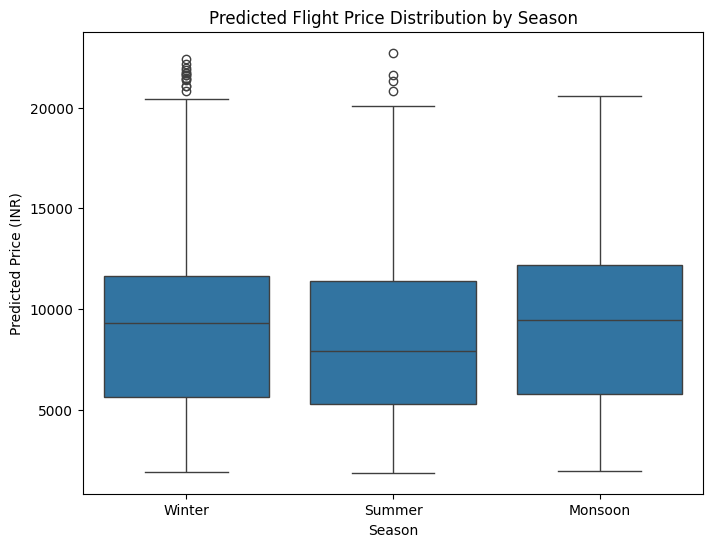

In [63]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Season', y='Predicted_Price', data=df_model)
plt.title('Predicted Flight Price Distribution by Season')
plt.ylabel('Predicted Price (INR)')
plt.show()


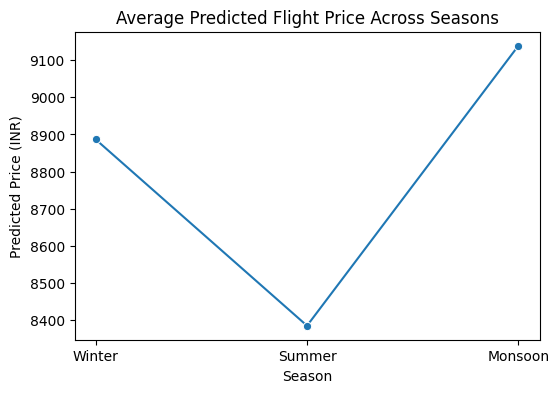

In [64]:
season_avg_pred = df_model.groupby('Season')['Predicted_Price'].mean().reindex(['Winter','Summer','Monsoon'])
plt.figure(figsize=(6,4))
sns.lineplot(x=season_avg_pred.index, y=season_avg_pred.values, marker='o')
plt.title('Average Predicted Flight Price Across Seasons')
plt.ylabel('Predicted Price (INR)')
plt.show()


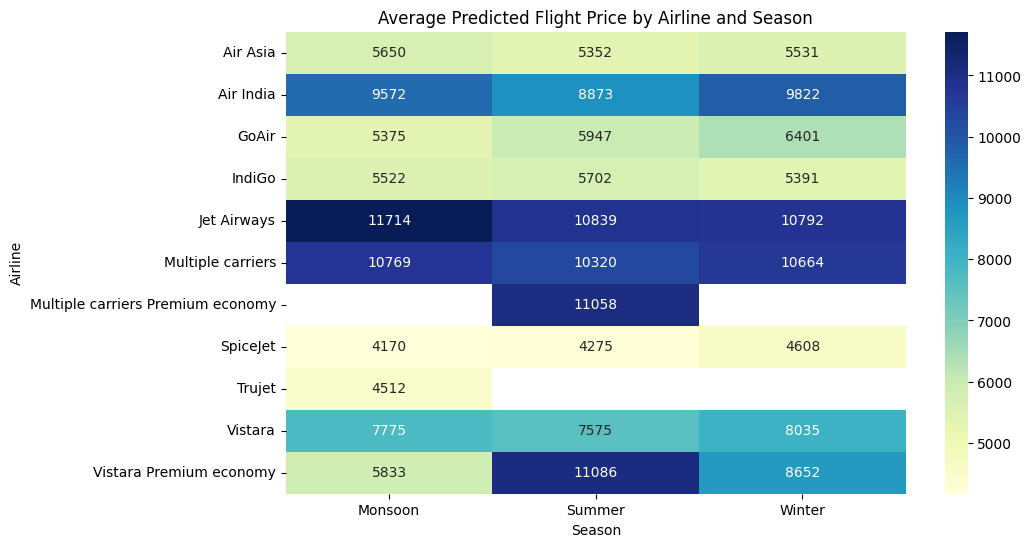

In [65]:
season_airline_pred = df_model.pivot_table(index='Airline', columns='Season', values='Predicted_Price', aggfunc='mean')
plt.figure(figsize=(10,6))
sns.heatmap(season_airline_pred, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('Average Predicted Flight Price by Airline and Season')
plt.ylabel('Airline')
plt.show()


In [67]:
df.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Dep_Time',
       'Duration', 'Price', 'Month', 'Season', 'Duration_min', 'Dep_hour'],
      dtype='object')

In [80]:
!pip install streamlit pyngrok --quiet


In [81]:
import joblib

# 'pipeline' is your trained XGBoost pipeline
joblib.dump(pipeline, 'xgboost_flight_price_pipeline.pkl')
print("XGBoost pipeline saved!")


XGBoost pipeline saved!


In [83]:
import joblib

pipeline = joblib.load('xgboost_flight_price_pipeline.pkl')
print(pipeline)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Airline', 'Source',
                                                   'Destination', 'Season',
                                                   'Route']),
                                                 ('num', StandardScaler(),
                                                  ['Duration_min', 'Dep_hour',
                                                   'Dep_minute', 'Weekday',
                                                   'Dep_hour_sin',
                                                   'Dep_hour_cos'])])),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_byleve...
                              feature_types=None, feature_weights=None,
                    

In [89]:
from google.colab import files

# Replace with the exact path if not in current working directory
files.download('xgboost_flight_price_pipeline.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [100]:
!pip install streamlit pyngrok --quiet
!pip install joblib pandas numpy --quiet


In [91]:
from google.colab import files
uploaded = files.upload()


Saving flights.csv to flights (1).csv
Saving xgboost_flight_price_pipeline.pkl to xgboost_flight_price_pipeline (1).pkl


In [3]:
import joblib
import pandas as pd
import numpy as np

# Load model and dataset
pipeline = joblib.load("xgboost_flight_price_pipeline.pkl")
df = pd.read_csv("flights.csv")


In [4]:
!pip install ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.9 MB/s eta 0:00:00


In [5]:
import joblib
import pandas as pd
import numpy as np
from datetime import datetime
import ipywidgets as widgets
from IPython.display import display


In [6]:
df = pd.read_csv("flights.csv")
pipeline = joblib.load("xgboost_flight_price_pipeline.pkl")


In [7]:
airline_dd = widgets.Dropdown(
    options=sorted(df['Airline'].unique()),
    description='Airline:',
    style={'description_width': 'initial'}
)

source_dd = widgets.Dropdown(
    options=sorted(df['Source'].unique()),
    description='Source:',
    style={'description_width': 'initial'}
)

destination_dd = widgets.Dropdown(
    options=sorted(df['Destination'].unique()),
    description='Destination:',
    style={'description_width': 'initial'}
)

dep_time_dd = widgets.Text(
    value='09:00',
    description='Departure Time (HH:MM):',
    style={'description_width': 'initial'}
)

duration_dd = widgets.Text(
    value='2h 30m',
    description='Duration (e.g., 2h 30m):',
    style={'description_width': 'initial'}
)

date_dd = widgets.Text(
    value='2025-01-18',
    description='Date (YYYY-MM-DD):',
    style={'description_width': 'initial'}
)

predict_btn = widgets.Button(
    description="Predict Price",
    button_style='success'
)

output_box = widgets.Output()


In [8]:
def predict_flight_price(b):
    with output_box:
        output_box.clear_output()

        airline = airline_dd.value
        source = source_dd.value
        destination = destination_dd.value
        dep_time = dep_time_dd.value
        duration = duration_dd.value
        date_str = date_dd.value

        # Date features
        date = pd.to_datetime(date_str)
        month = date.month
        weekday = date.weekday()

        if month in [12,1,2]:
            season = "Winter"
        elif month in [3,4,5,6]:
            season = "Summer"
        else:
            season = "Monsoon"

        # Time features
        time_obj = pd.to_datetime(dep_time, format="%H:%M")
        dep_hour = time_obj.hour
        dep_minute = time_obj.minute
        dep_hour_sin = np.sin(2*np.pi*dep_hour/24)
        dep_hour_cos = np.cos(2*np.pi*dep_hour/24)

        # Duration
        h, m = duration.lower().replace("h","").replace("m","").split()
        duration_min = int(h)*60 + int(m)

        # Route
        route = source + "-" + destination

        # DataFrame for model
        input_df = pd.DataFrame([{
            "Airline": airline,
            "Source": source,
            "Destination": destination,
            "Season": season,
            "Route": route,
            "Duration_min": duration_min,
            "Dep_hour": dep_hour,
            "Dep_minute": dep_minute,
            "Weekday": weekday,
            "Dep_hour_sin": dep_hour_sin,
            "Dep_hour_cos": dep_hour_cos
        }])

        # Predict
        y_log = pipeline.predict(input_df)[0]
        pred_price = np.expm1(y_log)

        print("==================================")
        print(f"Predicted Flight Price: ₹ {pred_price:.2f}")
        print("==================================")
